In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

#matplotlib.use('Agg')

In [10]:
class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        self.q_true = np.random.randn(self.k) + self.true_reward
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon: #exploration
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])
        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)
        q_best = np.max(self.q_estimation) #exploitation
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [11]:
def simulate(runs, steps, bandits):
    rewards = np.zeros((len(bandits), runs, steps))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs): #2000 runs for each bandit
            bandit.reset()
            for t in range(steps):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1) #size is (len(bandits), steps)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [4]:
def figure_2_1():
    plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10)) #+ np.random.randn(10)
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.savefig('figure_2_1_modified.png')
    plt.close()

In [12]:
'''x = np.random.randn(2, 4, 3)
print(x)
print(x.mean(axis=1))'''
def plot_figure_2_2(runs=2000, steps=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, steps, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.savefig('figure_2_2.png')
    plt.show()
    plt.close()
    
def plot_figure_2_3(runs=2000, steps=1000):
    bandit1 = Bandit(epsilon=0, step_size=0.1, initial=5.0)
    bandit2 = Bandit(epsilon=0.1, step_size=0.1, initial=5.0)
    best_action_counts, rewards = simulate(runs, steps, [bandit1, bandit2])
    plt.plot(best_action_counts[0]*100, label='Optimistic Greedy\nepsilon = 0, q1 = 5')
    plt.plot(best_action_counts[1]*100, label='Realistic e-greedy\nepsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.savefig('figure_2_3_exercise.png')
    plt.show()
    plt.close()
    
def plot_figure_2_4(runs=2000, steps=1000):
    bandit1 = Bandit(epsilon=0, UCB_param=2, sample_averages=True)
    bandit2 = Bandit(epsilon=0.1, sample_averages=True)
    best_action_counts, rewards = simulate(runs, steps, [bandit1, bandit2])
    plt.plot(rewards[0], label='UCB c=2')
    plt.plot(rewards[1], label=' e-greedy e=0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.savefig('figure_2_4_exercise.png')
    plt.show()
    plt.close()
def plot_figure_2_5(runs=2000, steps=1000):
    bandit1 = Bandit(gradient=True, gradient_baseline=True, step_size=0.1, true_reward=4)
    bandit2 = Bandit(gradient=True, gradient_baseline=True, step_size=0.4, true_reward=4)    
    bandit3 = Bandit(gradient=True, step_size=0.1, true_reward=4)
    bandit4 = Bandit(gradient=True , step_size=0.4, true_reward=4)
    best_action_counts, rewards = simulate(runs, steps, [bandit1, bandit2, bandit3, bandit4])
    plt.plot(best_action_counts[0]*100, label='with baseline alpha=0.1')
    plt.plot(best_action_counts[1]*100, label='with baseline alpha=0.4')
    plt.plot(best_action_counts[2]*100, label='without baseline alpha=0.1')
    plt.plot(best_action_counts[3]*100, label='without baseline alpha=0.4')
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()
    plt.savefig('figure_2_5_exercise.png')
    plt.show()
    plt.close()
def plot_figure_2_6(runs=2000, steps=1000):  
    bandits = []
    for i in range(-7,-1): #e-greedy first
        bandits.append(Bandit(epsilon=pow(2,i), sample_averages=True))
    for i in range(-5,2): #then gradient bandit
        bandits.append(Bandit(gradient=True, gradient_baseline=True, step_size=pow(2,i)))
    for i in range(-4,3): #then UCB
        bandits.append(Bandit(epsilon=0, UCB_param=pow(2,i), sample_averages=True))
    for i in range(-2,3): #then greedy with Optimistic Initialization
        bandits.append(Bandit(epsilon=0, step_size=0.1, initial=pow(2,i)))
    best_action_counts, rewards = simulate(runs, steps, bandits)
    rewards = np.mean(rewards, axis=1) #average over 1000 steps
    plt.plot(range(-7,-1), rewards[0:0+len(range(-7,-1))], label='e-greedy')
    plt.plot(range(-5,2), rewards[0+len(range(-7,-1)):0+len(range(-7,-1))+len(range(-5,2))], label='gradient bandit')
    plt.plot(range(-4,3), rewards[0+len(range(-7,-1))+len(range(-5,2)):0+len(range(-7,-1))+len(range(-5,2))+len(range(-4,3))], label='UCB')
    plt.plot(range(-2,3), rewards[0+len(range(-7,-1))+len(range(-5,2))+len(range(-4,3)):0+len(range(-7,-1))+len(range(-5,2))+len(range(-4,3))+len(range(-2,3))], label='Greedy with Optimistic Initialization')
    plt.xlabel('eps alpha c Q0 (2^x)')
    plt.ylabel('Average reward over 1000 steps')
    plt.legend()
    plt.savefig('figure_2_6_exercise.png')
    plt.show()
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.77it/s]


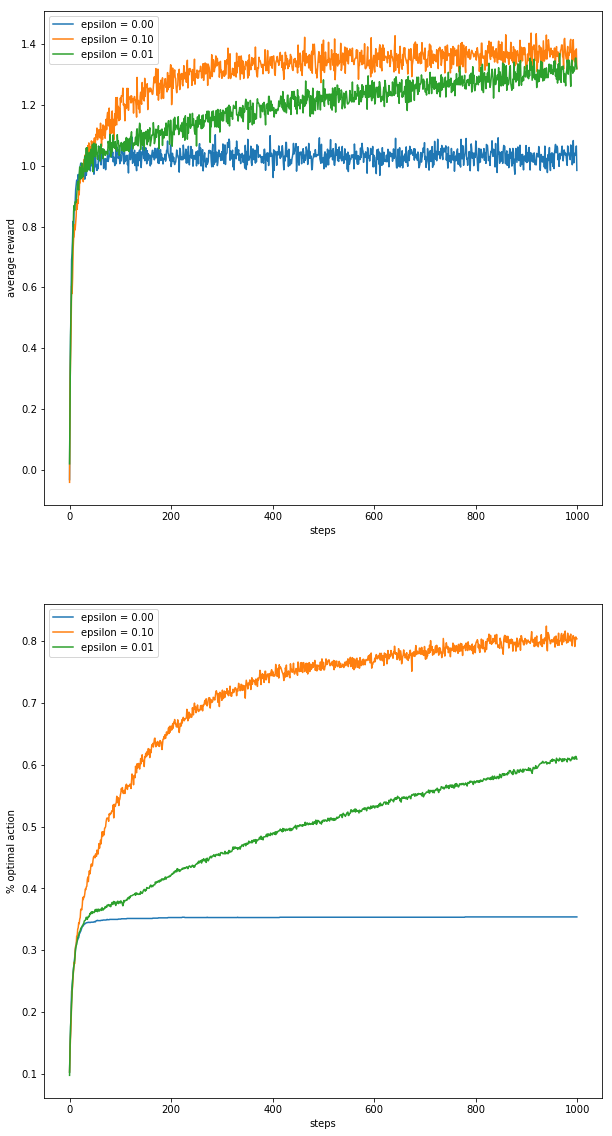

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.12it/s]


'q_estimation = np.zeros(10)\nq_best = np.max(q_estimation) #exploitation\nprint(np.where(q_estimation == q_best)[0])\nprint(np.random.choice(np.where(q_estimation == q_best)[0]))'

In [14]:
plot_figure_2_2()
#figure_2_1()
plot_figure_2_3()
plot_figure_2_4()
plot_figure_2_5()
plot_figure_2_6()
'''q_estimation = np.zeros(10)
q_best = np.max(q_estimation) #exploitation
print(np.where(q_estimation == q_best)[0])
print(np.random.choice(np.where(q_estimation == q_best)[0]))'''